Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


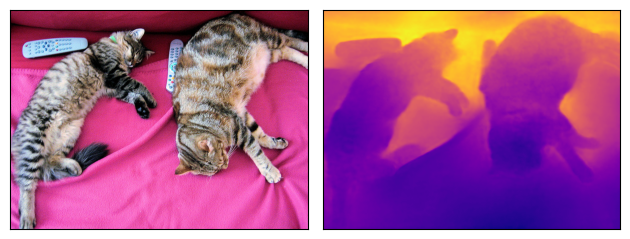

[Open3D WARNING] Write geometry::Image failed: unknown file extension.


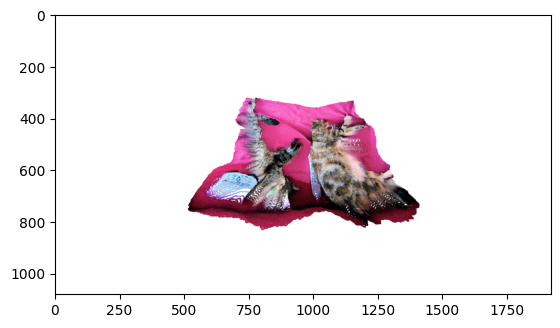

In [1]:
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import open3d as o3d

# loading image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# resizing image
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width/image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width,new_height)
image = image.resize(new_size)

# loading pre-train model for depth estimation
processor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

# model estimation
with torch.no_grad():
  outputs = model(**inputs)
  predicted_depth = outputs.predicted_depth

# post-processing
pad = 16
output = predicted_depth.squeeze().cpu().numpy() *1000
output = output[pad:-pad,pad:-pad]
image = image.crop((pad,pad,image.width-pad, image.height-pad))

# visualizing the prediction
fig , ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].tick_params(left = False , bottom = False , labelleft=False , labelbottom = False)
ax[1].imshow(output, cmap = 'plasma')
ax[1].tick_params(left = False , bottom = False , labelleft=False , labelbottom = False)
plt.tight_layout()
plt.pause(5)

# pre-process the depth image
width , height = image.size
depth_image = (output*255 / np.max(output)).astype('uint8')
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,depth_o3d,convert_rgb_to_intensity = False)

# Creating a Camera
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width , height, 500 , 500 , width/2, height/2)

# creating o3d point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)

# o3d.visualization.draw_geometries([pcd])
vis = o3d.visualization.Visualizer()
vis.create_window(visible = False)
vis.add_geometry(pcd)
img = vis.capture_screen_float_buffer(True)
plt.imshow(np.asarray(img))
path = "/visualize_path"
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.update_geometry(pcd)
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(path)
vis.destroy_window()